In [7]:
import sympy
import numpy as np
import scipy.optimize
import networkx as nx
from math import comb
import IPython.display as disp
from matplotlib import pyplot as plt

In [8]:
nk,alpha,p=sympy.Symbol("n_c"),sympy.Symbol(r"\alpha"),sympy.Symbol("p")


def pk(k,quarantines):
    """Probability of infection after k trials given the node is not infected before.
    """
    if quarantines:
        return p*(1-alpha)**k #quarantines
    else:
        return 1-(1-p)*(1-alpha)**(k-1) #the original complex contagion
    

def pkn(k,n,quarantines): # does this work for quarantines? we don't need to forget the quarantine outcome here
    """Same as pk, but when there are n infected neighbors simultaneously trying to infect.
    """
    if quarantines:
        prob=0
        for act in range(n):
            prob=prob+(alpha-1)**(act)*(pk(k+1,quarantines)-1)**(act)*pk(k+1,quarantines)
        return prob
    else:
        prob=1
        for act in range(n):
            prob=prob*(1-pk(k+1+act,quarantines))
        return 1-prob

def process_motif(node,graph,processed,notprocessed,quarantines,singleinftrial=True):
    nsus,ninf,nrec = node
    n=nsus+ninf+nrec
    if ninf>0:
        exp=0
        #Infect others in this clique
        for newinf in range(1,nsus+1):
            #Create the new node
            newnode=(nsus-newinf,newinf,nrec+ninf)
            if newnode not in processed:
                notprocessed.add(newnode)
            
            #Link from this node to the new node 
            if singleinftrial:
                prob=comb(nsus,newinf)*(pk(nrec,quarantines)**newinf)*((1-pk(nrec,quarantines))**(nsus-newinf))
            else:
                prob=comb(nsus,newinf)*(pkn(nrec,ninf,quarantines)**newinf)*((1-pkn(nrec,ninf,quarantines))**(nsus-newinf))
            #prob=comb(nsus,newinf)*(pk(nrec,quarantines)**newinf)*((1-pk(nrec,quarantines))**(nsus-newinf))
            graph.add_edge(node,newnode,weight=prob)
            exp=exp+newinf*prob
        
        #Infect new cliques
        if nsus>0:
            graph.add_edge(node,(n-1,1,0),weight=(nk-1)*exp)
            #graph.add_edge(node,(n-1,1,0),weight=nsus*(nk-1)*pkn(nrec,ninf,quarantines))
            
def pkn_persistent(n):
    """Same as pk, but when there are n infected neighbors simultaneously trying to infect.
    Note that this doesn't depend on k.
    """ 
    prob=0
    for act in range(n):
        prob=prob+(alpha-1)**(act)*(p-1)**(act)*p
    return prob


def process_motif_persistent(node,graph,processed,notprocessed,quarantines,singleinftrial=True):
    nsus,ninf,nrec = node
    n=nsus+ninf+nrec
    if ninf>0:
        exp=0 #expected number of infected nodes
        #Infect others in this clique
        for newinf in range(1,nsus+1): #number of newly infected
            for newrec in range(0,nsus+1-newinf): #number of newly quarantined
                #Create the new node
                newnode=(nsus-newinf-newrec,newinf,nrec+ninf+newrec)
                assert sum(newnode)==sum(node),(node,newnode)
                if newnode not in processed:
                    notprocessed.add(newnode)

                #Link from this node to the new node    
                if singleinftrial:
                    prob=comb(nsus,newinf)*comb(nsus-newinf,newrec)*p**newinf*(1-p)**(nsus-newinf-newrec)*alpha**newrec*(1-alpha)**(nsus-newrec)
                else:
                    prob=comb(nsus,newinf)*comb(nsus-newinf,newrec)*pkn_persistent(ninf)**newinf*(1-pkn_persistent(ninf))**(nsus-newinf-newrec)*alpha**newrec*(1-alpha)**(nsus-newrec)
                graph.add_edge(node,newnode,weight=prob)
                exp=exp+newinf*prob
            
        
        #Infect new cliques
        if nsus>0:
            graph.add_edge(node,(n-1,1,0),weight=(nk-1)*exp)
                  
def motif_graph(motifsize,quarantines=False,persistent=False,singleinftrial=True):
    """Creates a motif graph where nodes are motifs and links are weighted with probabilities of producing
    new motifs in one time step.
    
    Nodes are tuples with three items with following convention:
    (number of susceptible nodes, number of infected nodes, number of recovered nodes)
    
    Parameters
    ----------
    motifsize : The number of nodes in the motif
    quarantines : If 
    """
    if persistent:
        assert quarantines, "Persistent only works with quarantines."
    graph=nx.DiGraph()
    notprocessed=set([(motifsize-1,1,0)])
    processed=set()
    while len(notprocessed)>0:
        node = notprocessed.pop()
        processed.add(node)
        if persistent:
            process_motif_persistent(node,graph,processed,notprocessed,quarantines,singleinftrial)
        else:
            process_motif(node,graph,processed,notprocessed,quarantines,singleinftrial)
    return graph

def canonical_node_order(graph):
    nodes=sorted(graph.nodes(),key=lambda x:list(reversed(x))) #canonical order for nodes
    return nodes

def canonical_node_map(graph):
    nodes=canonical_node_order(graph)
    nodeid=dict(((node,i+1) for i,node in enumerate(nodes)))
    return nodeid

def get_M_matrix(graph,verbose=False):
    nodes=canonical_node_order(graph)
    nodeid=canonical_node_map(graph)
    M=sympy.matrices.zeros(len(nodes),len(nodes))
    if verbose: print(r"$(i,j)$ & $m_{ij}$ \\")
    for node in nodes:
        for neigh in sorted(graph.predecessors(node),key=lambda x:nodeid[x]):
            if verbose: print("$(",nodeid[node],",",nodeid[neigh],")$&",end="")
            if verbose: print("$",sympy.latex(sympy.simplify(graph[neigh][node]['weight'])),r"$\\")
            
            M[nodeid[node]-1,nodeid[neigh]-1]=graph[neigh][node]['weight']
    return M

def numeric_find_alpha(M,nkval,pval):
    Mn=M.subs(nk,nkval).subs(p,pval)
    n=len(M[0,:])
    try:
        alphaval=scipy.optimize.bisect(lambda x:sympy.det(Mn.subs(alpha,x)- sympy.eye(n)),0,1,xtol=0.0000001)
        return alphaval
    except ValueError:
        return np.NaN
    
def ratio(vector):
    v = vector[~np.isnan(vector)]
    return np.max(v)/np.min(v)

    
def print_motifs(g):
    nodes=canonical_node_order(g)
    print(r"$i$ & $S$ & $I$ & $R$ \\")
    print(r"\hline")
    for i in range(len(nodes)):
        node=nodes[i]
        print("$",i+1,"$&$", node[0],"$&$", node[1],"$&$", node[2],r"$\\")

largest_eigen_value = lambda M, A, P, n_c: np.max(np.linalg.eigvals(np.array(M.subs(nk,n_c).subs(alpha,A).subs(p, P), dtype=float)))


# $\textbf{M}$ Matrix for 3-clique

In [5]:
g=motif_graph(3,quarantines=True,persistent=True,singleinftrial=False)
print_motifs(g)
print()
M=get_M_matrix(g,verbose=True)
print()

#for critical solving alpha/p given p/alpha:
d=sympy.det(M - sympy.eye(len(g)))
print(sympy.latex(sympy.simplify(d)))

$i$ & $S$ & $I$ & $R$ \\
\hline
$ 1 $&$ 2 $&$ 1 $&$ 0 $\\
$ 2 $&$ 1 $&$ 1 $&$ 1 $\\
$ 3 $&$ 0 $&$ 2 $&$ 1 $\\
$ 4 $&$ 0 $&$ 1 $&$ 2 $\\

$(i,j)$ & $m_{ij}$ \\
$( 1 , 1 )$&$ 2 p \left(- \alpha n_{c} + \alpha + n_{c} - 1\right) $\\
$( 1 , 2 )$&$ - p \left(\alpha - 1\right) \left(n_{c} - 1\right) $\\
$( 2 , 1 )$&$ - 2 p \left(\alpha - 1\right)^{2} \left(p - 1\right) $\\
$( 3 , 1 )$&$ p^{2} \left(\alpha - 1\right)^{2} $\\
$( 4 , 1 )$&$ 2 \alpha p \left(1 - \alpha\right) $\\
$( 4 , 2 )$&$ p \left(1 - \alpha\right) $\\

- 2 \alpha^{3} n_{c} p^{3} + 2 \alpha^{3} n_{c} p^{2} + 2 \alpha^{3} p^{3} - 2 \alpha^{3} p^{2} + 6 \alpha^{2} n_{c} p^{3} - 6 \alpha^{2} n_{c} p^{2} - 6 \alpha^{2} p^{3} + 6 \alpha^{2} p^{2} - 6 \alpha n_{c} p^{3} + 6 \alpha n_{c} p^{2} + 2 \alpha n_{c} p + 6 \alpha p^{3} - 6 \alpha p^{2} - 2 \alpha p + 2 n_{c} p^{3} - 2 n_{c} p^{2} - 2 n_{c} p - 2 p^{3} + 2 p^{2} + 2 p + 1


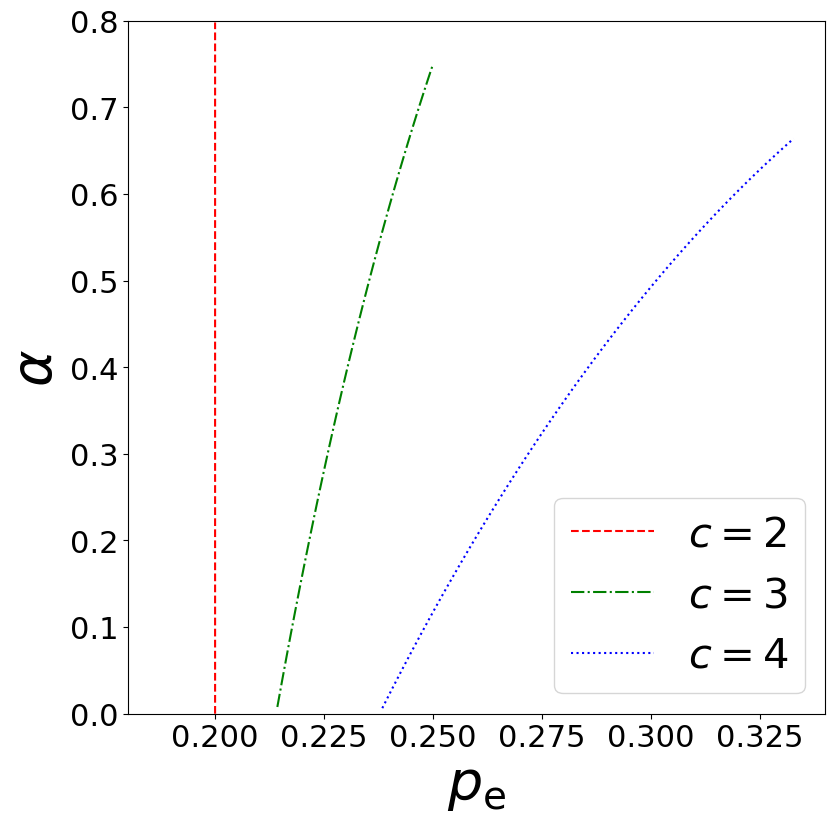

In [9]:
fig, axs = plt.subplots(figsize=(9,9))

k_nk_vals,ps,quarantines = [(2,6),(3,3),(4,2)],np.linspace(0.2,0.99,100),True
xmin=None
xmax=None
cr = ['r', 'g', 'b']
lins = ['dashed', 'dashdot', 'dotted']
_i = 0

approx_data = []
for kval,nkval in k_nk_vals:
    g = motif_graph(kval,quarantines=True,persistent=True,singleinftrial=False)
    M = get_M_matrix(g)
    alphas = [numeric_find_alpha(M,nkval,pval) for pval in ps]
    approx_data.append(alphas)
    axs.plot(ps*(1-np.array(alphas)) ,alphas,label=r"$c="+str(kval)+"$", color = cr[_i],linestyle=lins[_i], ms = 100)
    _i += 1
np.save("approx_data", approx_data)
if xmin==None: xmin=ps[0]
if xmax==None: xmax=ps[-1]
axs.set_xlim([.18, .34])
axs.set_ylim([0, .8])
axs.set_xlabel(r'$p_{\mathrm{e}}$' , fontsize = 40)
axs.set_ylabel(r'$\alpha$' , fontsize = 40)
axs.tick_params(axis='y', labelsize= 22)
axs.tick_params(axis='x', labelsize= 22)
axs.legend(loc = 4, fontsize = 30)
#plt.savefig('mfield2-rescx.pdf')

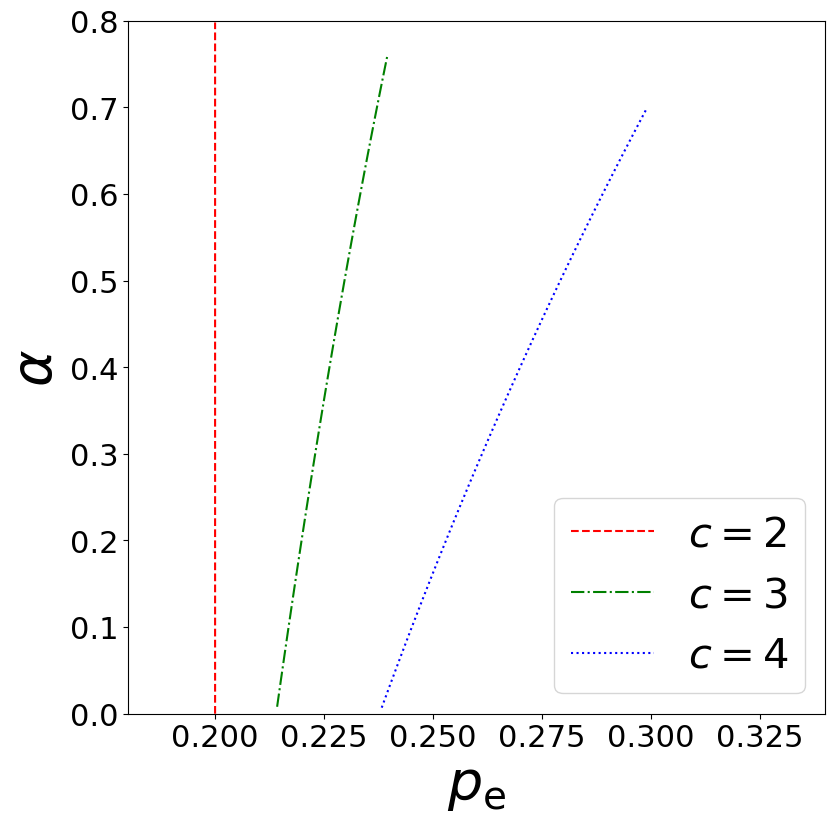

In [10]:
fig, axs = plt.subplots(figsize=(9,9))

k_nk_vals,ps,quarantines = [(2,6),(3,3),(4,2)],np.linspace(0.2,0.99,100),True
xmin=None
xmax=None
cr = ['r', 'g', 'b']
lins = ['dashed', 'dashdot', 'dotted']
_i = 0

approx_data2 = []
for kval,nkval in k_nk_vals:
    g = motif_graph(kval,quarantines=True,persistent=False,singleinftrial=False)
    M = get_M_matrix(g)
    alphas = [numeric_find_alpha(M,nkval,pval) for pval in ps]
    approx_data2.append(alphas)
    axs.plot(ps*(1-np.array(alphas)) ,alphas,label=r"$c="+str(kval)+"$", color = cr[_i],linestyle=lins[_i], ms = 100)
    _i += 1

np.save("approx_data2", approx_data2)

if xmin==None: xmin=ps[0]
if xmax==None: xmax=ps[-1]
axs.set_xlim([.18, .34])
axs.set_ylim([0, .8])
axs.set_xlabel(r'$p_{\mathrm{e}}$' , fontsize = 40)
axs.set_ylabel(r'$\alpha$' , fontsize = 40)
axs.tick_params(axis='y', labelsize= 22)
axs.tick_params(axis='x', labelsize= 22)
axs.legend(loc = 4, fontsize = 30)
plt.savefig('mfield2-rescx.pdf')

In [11]:
ALPHAS = np.load('ALPHAS.npy')
PA = np.load('PA.npy')

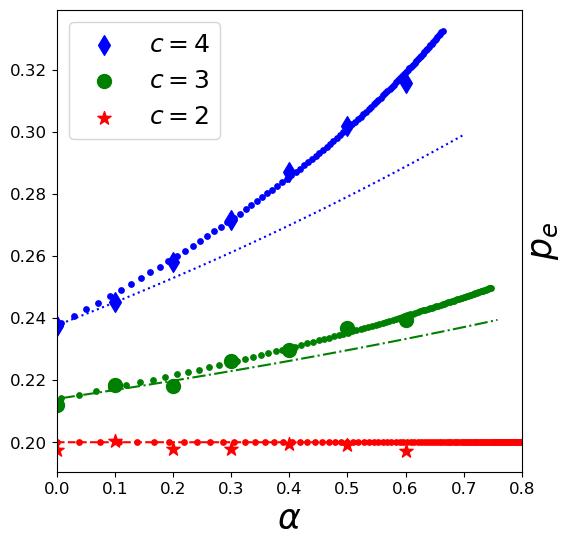

In [12]:
fig, axs = plt.subplots(figsize=(6,6))

cr = ['r', 'g', 'b']
lins = ['dashed', 'dashdot', 'dotted']
_i = 0

for kval,nkval in k_nk_vals:
    alphas2 = approx_data[_i]
    alphas = approx_data2[_i]
    axs.plot(alphas,ps*(1-np.array(alphas)), color = cr[_i],linestyle=lins[_i])
    axs.scatter(alphas2, ps*(1-np.array(alphas2)) ,color = cr[_i], s = 15)

    _i += 1
if xmin==None: xmin=ps[0]
if xmax==None: xmax=ps[-1]

for _j in range(len(PA)):
    #axs.scatter(ALPHAS[_j],PA[_j],  marker = '*', s = 200, color = 'gray')
    if _j != 0:
        axs.scatter(ALPHAS[_j][0],PA[_j][0]*(1-ALPHAS[_j][0]),  marker = '*', s = 100, color =cr[0])
        axs.scatter(ALPHAS[_j][1],PA[_j][1]*(1-ALPHAS[_j][1]),  marker = 'o', s = 100, color = cr[1])
        axs.scatter(ALPHAS[_j][2],PA[_j][2]*(1-ALPHAS[_j][2]),  marker = 'd', s = 100, color = cr[2])
    else:
        axs.scatter(ALPHAS[_j][2],PA[_j][2]*(1-ALPHAS[_j][2]),  marker = 'd', s = 100, color = cr[2], label=r"$c="+str(4)+"$", )
        axs.scatter(ALPHAS[_j][1],PA[_j][1]*(1-ALPHAS[_j][1]),  marker = 'o', s = 100, color = cr[1], label=r"$c="+str(3)+"$", )
        axs.scatter(ALPHAS[_j][0],PA[_j][0]*(1-ALPHAS[_j][0]),  marker = '*', s = 100, color =cr[0], label=r"$c="+str(2)+"$", )

    
axs.set_xlim([0.0, .8])

axs.set_ylabel(r'$ p_e$', fontsize = 25)
axs.yaxis.set_label_position("right")
axs.set_xlabel(r'$\alpha$' , fontsize = 25)
axs.tick_params(axis='y', labelsize= 12)
axs.tick_params(axis='x', labelsize= 12)
axs.legend(fontsize = 18)
plt.savefig('mfields-rescx.pdf')

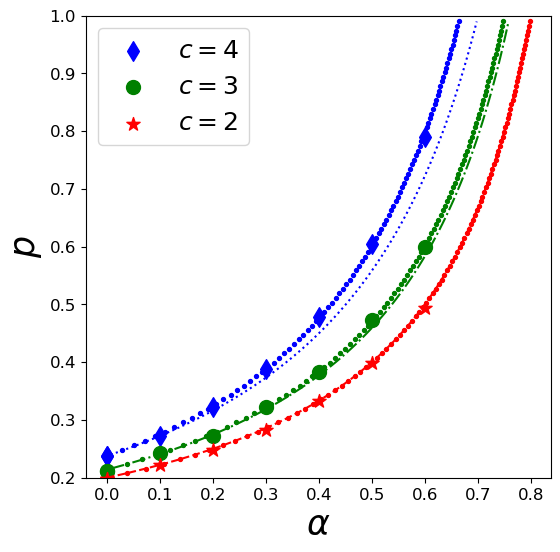

In [11]:
fig, axs = plt.subplots(figsize=(6,6))
cr = ['r', 'g', 'b']
lins = ['dashed', 'dashdot', 'dotted']
_i = 0
for kval,nkval in k_nk_vals[::-1]:
    alphas2 = approx_data[_i]
    alphas = approx_data2[_i]
    axs.plot(alphas,ps , color = cr[_i],linestyle=lins[_i])
    axs.scatter(alphas2, ps ,color = cr[_i], s = 8)
    _i += 1


for _j in range(len(PA)):
    #axs.scatter(ALPHAS[_j],PA[_j],  marker = '*', s = 200, color = 'gray')
    axs.scatter(ALPHAS[_j][2],PA[_j][2],  marker = 'd', s = 100, color = cr[2])
    axs.scatter(ALPHAS[_j][1],PA[_j][1],  marker = 'o', s = 100, color = cr[1])
    axs.scatter(ALPHAS[_j][0],PA[_j][0],  marker = '*', s = 100, color =cr[0])
    
    if  _j == 0:
        #axs.scatter(ALPHAS[_j],PA[_j],  marker = '*', s = 200, color = 'gray')
        axs.scatter(ALPHAS[_j][2],PA[_j][2],  marker = 'd', s = 100, color = cr[2], label=r"$c="+str(4)+"$")
        axs.scatter(ALPHAS[_j][1],PA[_j][1],  marker = 'o', s = 100, color = cr[1], label=r"$c="+str(3)+"$" )
        axs.scatter(ALPHAS[_j][0],PA[_j][0],  marker = '*', s = 100, color =cr[0], label=r"$c="+str(2)+"$")


axs.set_ylim([0.2, 1])
axs.set_ylabel(r'$p$' , fontsize = 25)
axs.set_xlabel(r'$\alpha$' , fontsize = 25)
axs.tick_params(axis='y', labelsize= 12)
axs.tick_params(axis='x', labelsize= 12)
axs.legend(fontsize = 18)
plt.savefig('mfields.pdf')

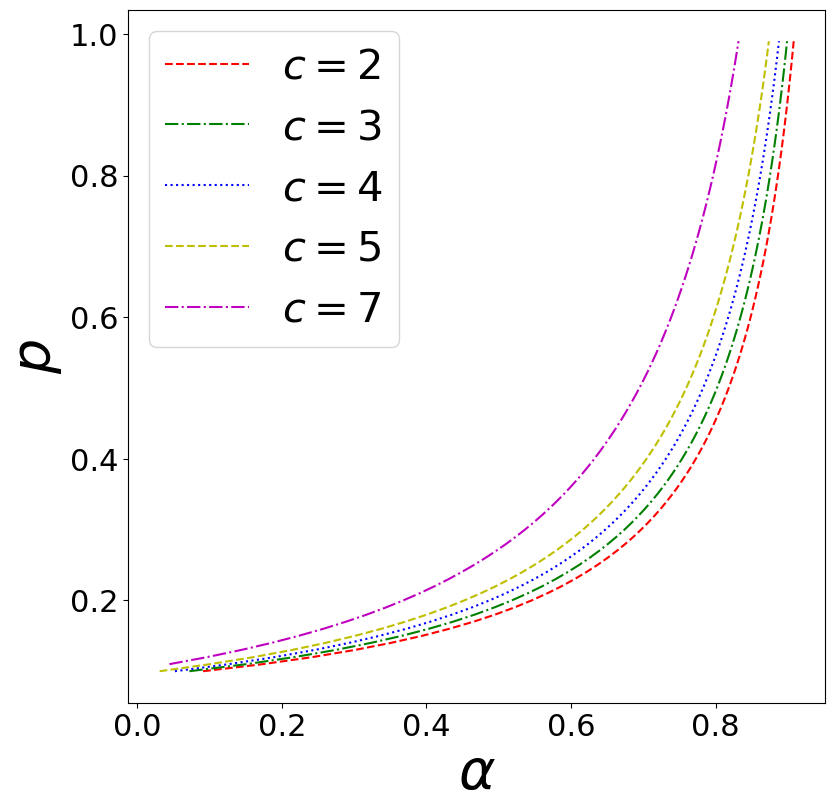

In [12]:
quarantines=True
rescalex=True
xmin=0.15
xmax=0.35
persistent=True

Aalphas = np.load('alphas_for_12_mikko.npy')

fig, axs = plt.subplots(figsize=(9,9))

k_nk_vals,ps,quarantines = [(2,12),(3,6),(4,4),(5,3),(7,2)],np.linspace(0.0,0.99,100),True
#xmin=None
#xmax=None
cr = ['r', 'g', 'b', 'y', 'm', 'c']
lins = ['dashed', 'dashdot', 'dotted', 'dashed', 'dashdot', 'dotted']
_i = 0

for kval,nkval in k_nk_vals:
  
    axs.plot(Aalphas[_i],ps, label=r"$c="+str(kval)+"$", color = cr[_i],linestyle=lins[_i] )
    #if _i == 0:
        
        #axs.fill_between(list(np.linspace(0.0,0.2,20))+list(np.linspace(0.2,0.99,100)),
                         #[0 for _ in list(np.linspace(0.0,0.2,20))]+list(alphas) , 1, color='black', alpha=.1)
    _i += 1
if xmin==None: xmin=ps[0]
if xmax==None: xmax=ps[-1]
#axs.set_ylim([.18, .34])
#axs.set_xlim([0.4, .9])
axs.set_ylabel(r'$p$' , fontsize = 40)
axs.set_xlabel(r'$\alpha$' , fontsize = 40)
axs.tick_params(axis='y', labelsize= 22)
axs.tick_params(axis='x', labelsize= 22)
axs.legend( fontsize = 30)

plt.savefig('12_Pmfield.pdf')   

0.8264460213913319
0.9277729845473193
1.053004644548583
1.2105875835408249
1.4449519581686978


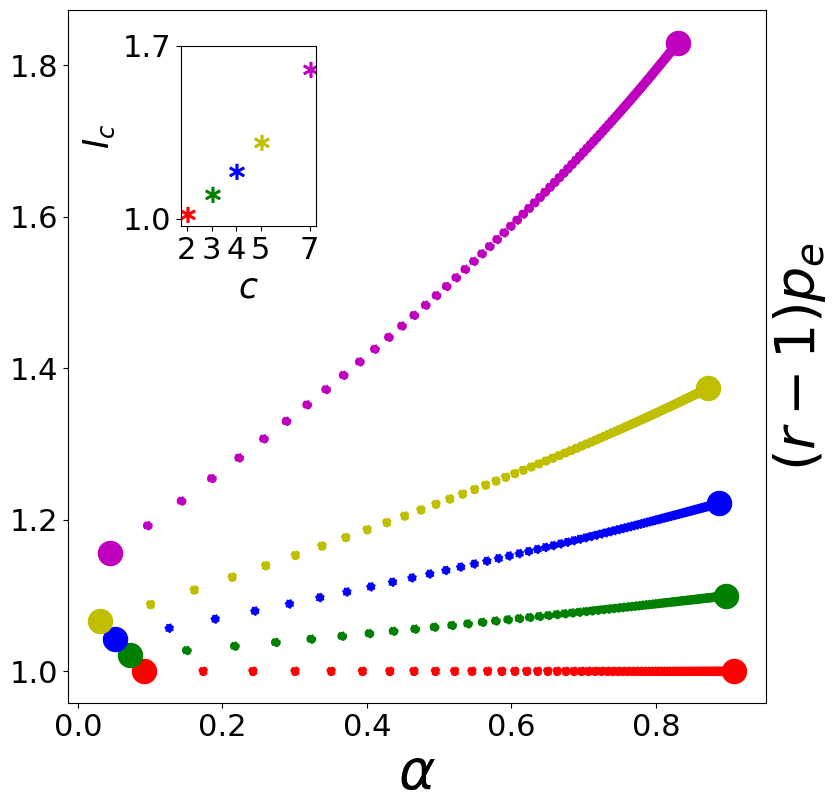

In [13]:
cr = ['r', 'g', 'b', 'y', 'm', 'c']
lins = ['dashed', 'dashdot', 'dotted', 'dashed', 'dashdot', 'dotted']
fig, axs = plt.subplots(figsize=(9,9))
left, bottom, width, height = [0.25, 0.64, 0.15, 0.2]
ax2 = fig.add_axes([left, bottom, width, height])

ps = np.linspace(0.0,0.99,100)
critsP = []
for _i in [0,1,2,3,4]:
    alphas = np.array(Aalphas[_i])
    axs.scatter(alphas,11*ps*(1-np.array(alphas)), label=r"$c="+str(kval)+"$", color = cr[_i],linestyle=lins[_i] )
    if _i == 0:
        axs.scatter(alphas[-1], 11*ps[-1]*(1-np.array(alphas[-1])), color = cr[_i], s = 300)
        axs.scatter(alphas[10], 11*ps[10]*(1-np.array(alphas[10])), color = cr[_i], s = 300)
        xxx = ps[-1]*(1-np.array(alphas[-1]))/ps[10]*(1-np.array(alphas[10]))
        print(xxx)
        critsP.append(xxx)
    elif _i == 1:
        axs.scatter(alphas[-3], 11*ps[-3]*(1-np.array(alphas[-3])), color = cr[_i], s = 300)
        axs.scatter(alphas[10], 11*ps[10]*(1-np.array(alphas[10])), color = cr[_i], s = 300)
        xxx = ps[-3]*(1-np.array(alphas[-3]))/ps[10]*(1-np.array(alphas[10]))
        print(xxx)
        critsP.append(xxx)
        
    elif _i == 4:
        axs.scatter(alphas[-2], 11*ps[-2]*(1-np.array(alphas[-2])), color = cr[_i], s = 300)
        axs.scatter(alphas[11], 11*ps[11]*(1-np.array(alphas[11])), color = cr[_i], s = 300)
        xxx = ps[-2]*(1-np.array(alphas[-2]))/ps[11]*(1-np.array(alphas[11]))
        print(xxx)
        critsP.append(xxx)
    else:
        axs.scatter(alphas[-2], 11*ps[-2]*(1-np.array(alphas[-2])), color = cr[_i], s = 300)
        axs.scatter(alphas[10], 11*ps[10]*(1-np.array(alphas[10])), color = cr[_i], s = 300)
        xxx = ps[-2]*(1-np.array(alphas[-2]))/ps[10]*(1-np.array(alphas[10]))
        print(xxx)
        critsP.append(xxx)

for cc in range(5):
    cccc = [2,3,4,5,7]
    ax2.scatter(cccc[cc], ratio(ps*(1-np.array(Aalphas[cc]))), marker = '$*$', s = 300, color = cr[cc])


ax2.set_xticks([2, 3, 4, 5, 7])
ax2.set_yticks([1, 1.7])

ax2.set_ylabel(r'$I_c$' , fontsize = 25)
ax2.set_xlabel(r'$c$' , fontsize = 25)
ax2.tick_params(axis='y', labelsize= 22)
#ax2.yaxis.set_label_position("right")
#ax2.yaxis.tick_right()
ax2.tick_params(axis='x', labelsize= 22)

axs.set_ylabel(r'$(r-1) p_e $' , fontsize = 40)
axs.set_xlabel(r'$\alpha$' , fontsize = 40)
axs.tick_params(axis='y', labelsize= 22)
axs.tick_params(axis='x', labelsize= 22)
axs.set_yticks(np.arange(1, 2., .2))
axs.yaxis.set_label_position("right")
plt.savefig('d12_Pmfield-rescx2.pdf')   

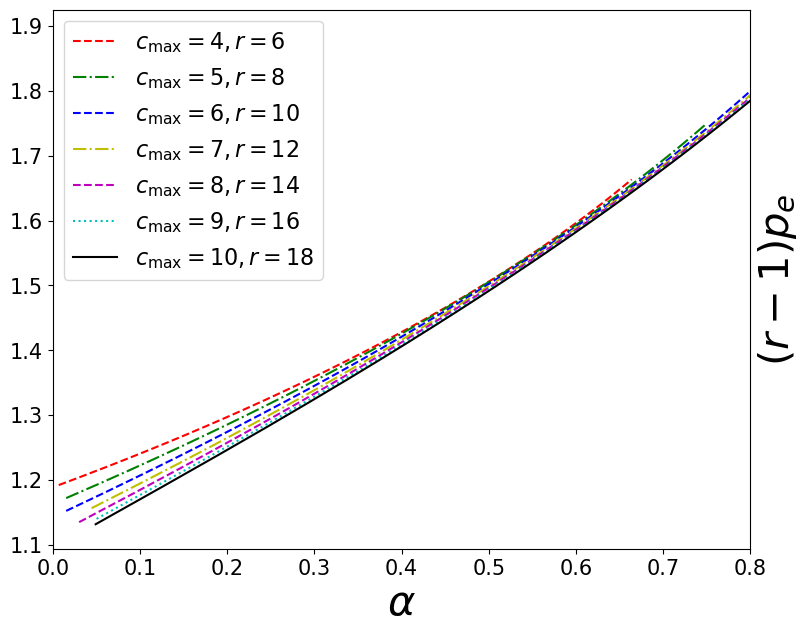

In [3]:
fig, axs = plt.subplots(figsize=(9,7))
k_nk_vals = [(c_max,2) for c_max in range(4, 11)]

ps,quarantines = np.linspace(0.,0.99,100),True
xmin=None
xmax=None
cr = ['r', 'g', 'b', 'y', 'm', 'c', 'k']
lins = ['dashed', 'dashdot',  'dashed', 'dashdot',  'dashed','dotted','solid', ]
_i = 0

rd_data = np.load('all.npy')    

for kval,nkval in k_nk_vals:
    alphas = rd_data[_i]
    axs.plot(alphas,((kval-1)*nkval-1)*ps*(1-np.array(alphas)) ,label=r"$c_\mathrm{max}="+str(kval)+', '+"$"+r"$r="+str((kval-1)*nkval)+"$", color = cr[_i],linestyle=lins[_i], ms = 100)
    _i += 1
    
    
if xmin==None: xmin=ps[0]
if xmax==None: xmax=ps[-1]
axs.set_xlim([.0, .8])
#axs.set_ylim([1, 1.8])
axs.set_ylabel(r'$(r-1) p_e $' , fontsize = 30)
axs.set_xlabel(r'$\alpha$' , fontsize = 30)
axs.tick_params(axis='y', labelsize= 15)
axs.tick_params(axis='x', labelsize= 15)
axs.yaxis.set_label_position("right")

axs.legend(fontsize = 16)
plt.savefig('mfrescx.pdf')